# Introduction to Data Science

This introductory course is designed for beginners with little to no prior experience in data science and machine learning (ML). However, a basic understanding of Python syntax and statistics is necessary. The module is divided into three sections: (1) data pre-processing, (2) model training, (3) model evaluation.

The main focus of this module is to teach you how to effectively train an ML model. Therefore, Instead of delving deeply into the underlying theories, we will focus on implementation. In the first section, we will cover three popular data pre-processing techniques: standard scaling, principal component analysis, and label encoding. The second section focuses on ML model training and introduces grid search cross-validation, a parameter tuning method to improve model performance. Finally, the third section covers model evaluation, where we assess its effectiveness using metrics like accuracy and the confusion matrix.

In [1]:
### Python Libraries ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
### Python Libraries ###

## SECTION 1: Data Pre-processing

Let's begin by reviewing the dataset we'll be working with. A clear understanding of the dataset is essential for making informed decisions regarding model and feature selection. In this tutorial, we will use the Dry Bean Classification dataset, which includes 16 features and 7 distinct classes: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz, and Sira. Features are the input variables that the model uses to make predictions, and classes refer to the categories or labels. For more details about the features and bean types, please visit https://archive.ics.uci.edu/dataset/602/dry+bean+dataset.

#### STEP 1: Load and Read the Dataset

In [2]:
Dataset = pd.read_excel('Dry_Bean_Dataset.xlsx')        # Load the dataset into a pandas DataFrame
print(Dataset)

        Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0      28395    610.291       208.178117       173.888747      1.197191   
1      28734    638.018       200.524796       182.734419      1.097356   
2      29380    624.110       212.826130       175.931143      1.209713   
3      30008    645.884       210.557999       182.516516      1.153638   
4      30140    620.134       201.847882       190.279279      1.060798   
...      ...        ...              ...              ...           ...   
13606  42097    759.696       288.721612       185.944705      1.552728   
13607  42101    757.499       281.576392       190.713136      1.476439   
13608  42139    759.321       281.539928       191.187979      1.472582   
13609  42147    763.779       283.382636       190.275731      1.489326   
13610  42159    772.237       295.142741       182.204716      1.619841   

       Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0          0.54981

#### STEP 2: Seperate Feature and Target

Here, we will separate the dataset into FeatureData (independent variables) and TargetData (dependent variable) segments. In classification, the terms target and class are sometimes used interchangeably, but there is a key difference. Target refers to the actual label in the dataset that the model will learn to predict, while class refers to one of the possible categories the target can belong to.

In [3]:
TargetData = Dataset['Class']                               # Extract target colum 'Class'
FeatureData = Dataset.drop('Class', axis='columns')         # Only remove the target column

#### STEP 3: Visualize Classes

We create a pie chart to visualize the percentage of each class, helping us better understand the distribution of the target variable in the dataset. This allows us to assess whether there is a significant imbalance among the classes, which could impact model performance in real-world applications. In our case, the classes are not equally distributed, and there is a noticeable gap between Bombay and Dermason. However, the imbalance is not severe enough to cause major concern.

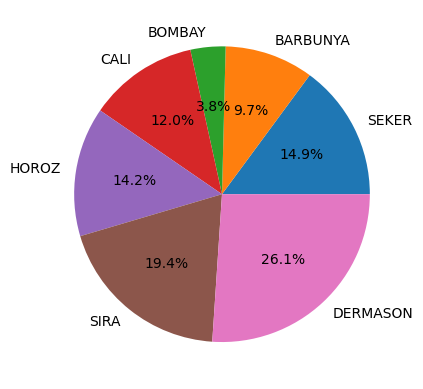

In [4]:
ClassDir = Counter(TargetData)              # Counter calculates occurrences of each class
y = np.array(list(ClassDir.values()))       # Converting ClassDir to NumPy array for plotting
labels = list(ClassDir.keys())              # Extract the class labels from the counter
plt.pie(y,                                  # Create a pie char
        labels=labels, 
        autopct='%1.1f%%');                 # Display percentages with one decimal place

#### STEP 4: Visualize Features

We create a horizontal bar chart to visualize the mean values of the features in the dataset. This helps us analyze and compare the scale of the features and select appropriate data preprocessing techniques. 

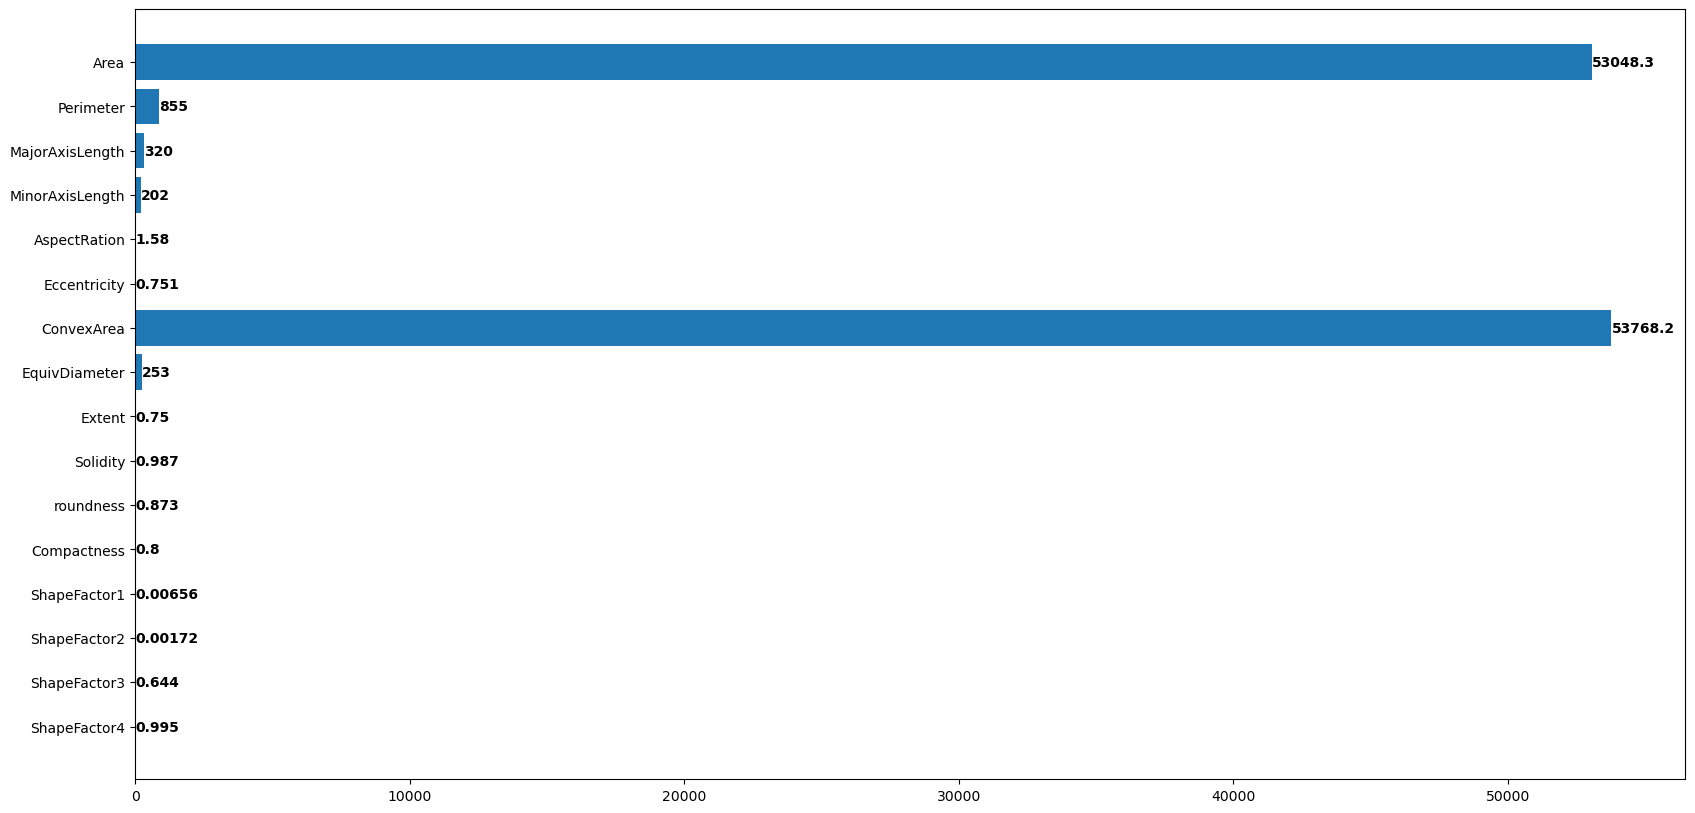

In [5]:
FeatureMean = FeatureData.mean().to_dict() 
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(list(FeatureMean.keys()), list(FeatureMean.values()))
ax.invert_yaxis()
for values in ax.patches:
    plt.text(
             s=f'{values.get_width():.3g}' if values.get_width() < 1000 else f'{values.get_width():.6g}',
             x=values.get_width(),
             y=values.get_y()+0.5,
             fontsize=10,
             fontweight ='bold')

#### STEP 5: Apply StandardScaler

As you can see in the image above, features such as ConvexArea and Solidity differ greatly in magnitude, with ConvexArea values in the thousands and Solidity values in decimals. This disparity in scale can cause the model to favor ConvexArea simply because its values are larger. To avoid this bias, we apply the StandardScaler to normalize the data. This process ensures that all features are placed on the same scale, allowing the model to treat each feature equally and impartially.

In [6]:
Scaler = StandardScaler().set_output(transform="pandas")
SSFeatureData = Scaler.fit_transform(FeatureData)

#### STEP 6: Visualize Features After Standard Scaling

Once you generate the bar chart using the cell below, you will notice a significant shift in the means of all the features. You’ll observe that their magnitudes are now close to zero, with some features that previously had positive values now shifted to negative. To rescale the data, the StandardScaler first subtracts the feature's mean and then divides by its standard deviation. As a result, the mean of some features may become negative.

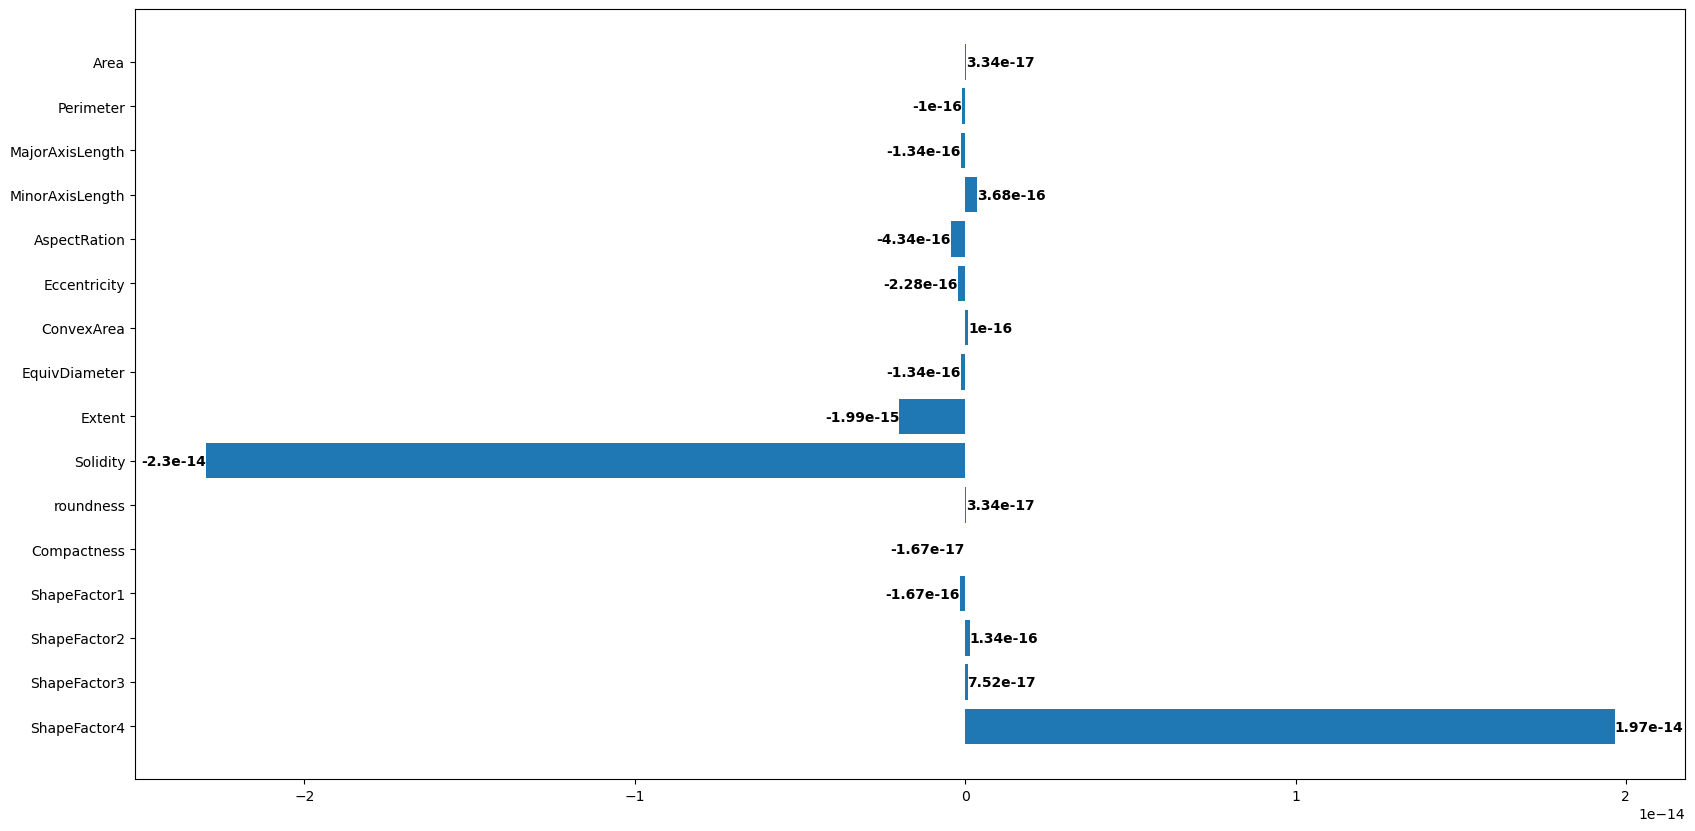

In [7]:
FeatureMean = SSFeatureData.mean().to_dict()
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(list(FeatureMean.keys()), list(FeatureMean.values()))
ax.invert_yaxis()
for values in ax.patches:
    plt.text(s=f'{values.get_width():.3g}',
             x=values.get_width(),
             y=values.get_y()+0.5,
             fontsize=10,
             fontweight ='bold',
             ha='right' if values.get_width() < 0 else 'left')

#### STEP 7: Apply Principal Componenet Analysis (PCA) 

PCA is a data dimensionality reduction technique, which lowers the risk of 
overfitting and speeds up the training process. Overfitting occurs when a model excels 
on training data but performs poorly on test data, often because it has captured noise 
or irrelevant patterns from an abundance of features. By uncovering the essential structure
in the data, PCA reduces the number of features while preserving the model's accuracy.

#### STEP 8: Visualize Feature Correlation before PCA

When you run the code below, it will generate a heatmap illustrating the linear relationships between different features in the dataset. The correlation is measured on a scale from -1 to 1. Values closer to 1 indicate a positive correlation, meaning that as one feature increases, the other feature increases proportionally. Values closer to -1 represent a negative correlation, meaning that as one feature increases, the other decreases proportionally. Values near 0 suggest no linear correlation, indicating no significant relationship between the two features. Ideally, we want feature combinations with correlations close to zero, as this ensures each feature contributes unique information to the model and prevents redundancy.

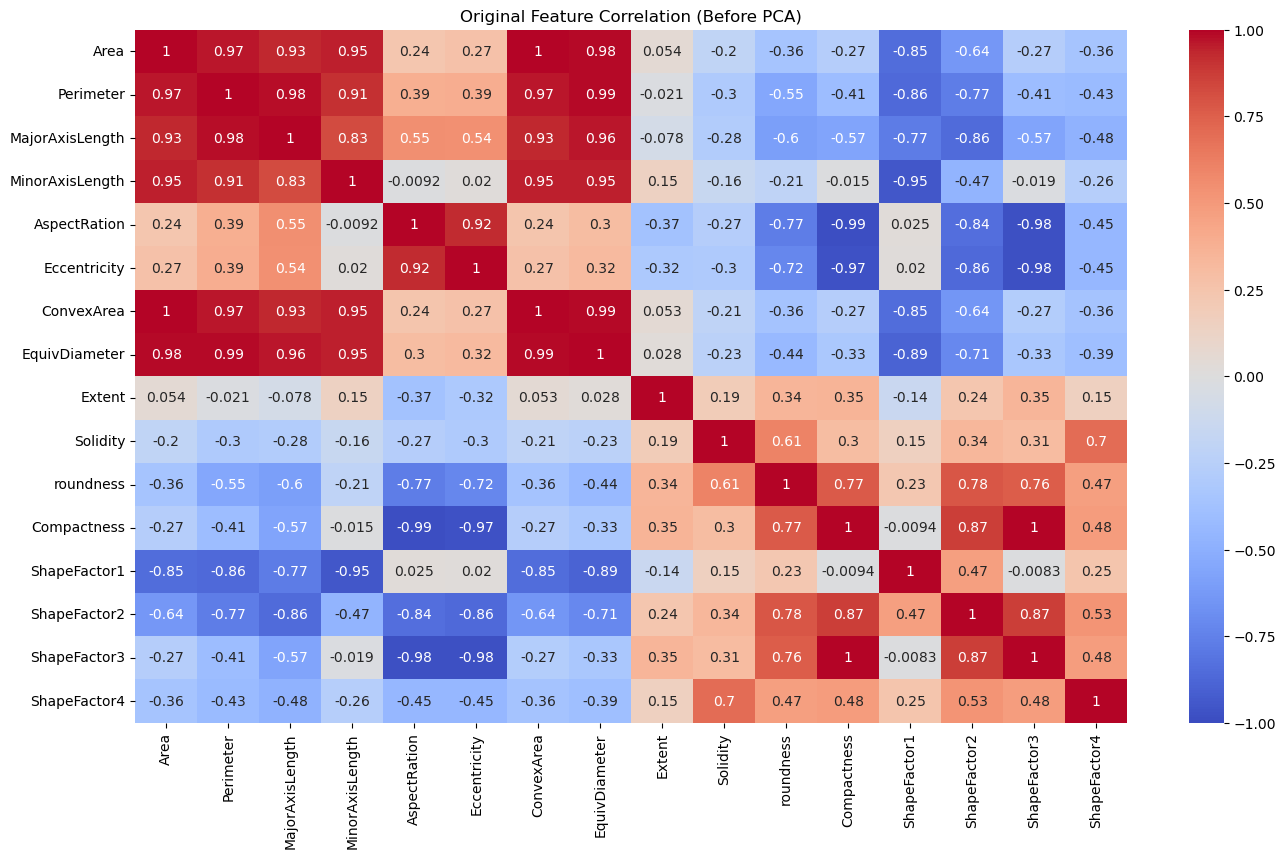

In [8]:
plt.figure(figsize=(16, 9))
sns.heatmap(SSFeatureData.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Original Feature Correlation (Before PCA)')
plt.show()

#### STEP 9: Apply PCA

We set n_components=8 in the PCA function to reduce the dimensionality of the input data to 8 principal components. These components are determined based on the covariance matrix. The value of n_components is selected through trial and error. Each principal component is a linear combination of the original features in the dataset, where the weights (or coefficients) are determined by the amount of variance that component captures in the data.

In [9]:
PCAnalysis = PCA(n_components=8)
SSAndPCAFeatureData = PCAnalysis.fit_transform(SSFeatureData)
print(SSAndPCAFeatureData)

[[-4.98156099  1.82469731 -0.74902104 ...  0.30121225 -0.61026865
   0.27480202]
 [-5.43679225  2.9323648  -2.18237398 ...  0.04557491 -1.69134198
   0.31765362]
 [-4.7580883   1.82688385 -0.5140376  ...  0.2085379  -0.59956313
   0.16209032]
 ...
 [-1.41751472  0.1411937   0.38720635 ... -0.13733302  0.3333777
  -0.03788353]
 [-1.11466584 -0.21267932 -0.14408831 ... -0.09716026  0.3586018
  -0.03483897]
 [-0.76643686 -0.64651411  0.99412157 ...  0.05216271  0.2958651
   0.04708744]]


#### STEP 10: Visualize Feature Correlation After PCA

After generating the image below, you can see that, aside from the diagonal line (which always contains 1s and can be disregarded), all other values are close to 0. This demonstrates that redundant features have been removed from the training dataset, as the principal components are now uncorrelated, capturing unique information.

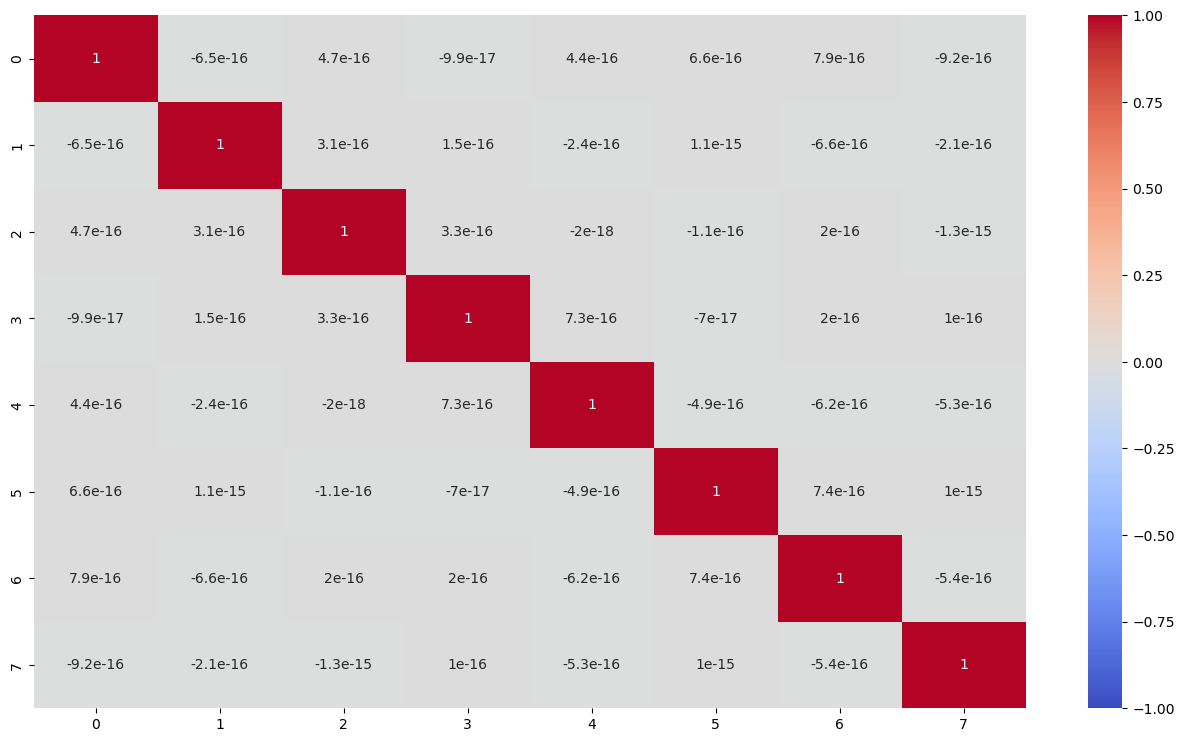

In [10]:
plt.figure(figsize=(16, 9))
sns.heatmap(pd.DataFrame(SSAndPCAFeatureData).corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.show()

#### STEP 11: Encode the labels

Label Encoder converts text labels into numbers, which is essential because many machine learning models, including the one used in this tutorial, require numeric input for computation. After running the following code, you’ll see that each text label has been assigned a number. For example, Sira is assigned the number 6, while Cali is assigned the number 2.

In [11]:
Encoder = LabelEncoder()
LETargetData = Encoder.fit_transform(TargetData)
for Idx, LabelName in enumerate(Encoder.classes_):
    print(f'{LabelName}: {Idx}')

BARBUNYA: 0
BOMBAY: 1
CALI: 2
DERMASON: 3
HOROZ: 4
SEKER: 5
SIRA: 6


## SECTION 2: Model Training

#### STEP 12: Split the dataset train and test segments

Using the train_test_split function, we divide the data into training and testing sets. Splitting the dataset allows us to test the model on unseen data, which is crucial for evaluating its performance in real-world scenarios. 

By setting test_size=0.2, we allocate 20% of the data for testing, while the remaining 80% is used for training. The random_state=42 ensures the data is shuffled consistently each time, making the results reproducible. Shuffling the data is important to prevent the model from learning unintended patterns based on the order of the data.

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(SSAndPCAFeatureData, LETargetData, test_size=0.2, random_state=42)

#### STEP 13: Initialize the model

In this tutorial, we will train a Support Vector Classifier (SVC), a classification algorithm from the Support Vector Machine (SVM) family. SVC can handle both linear and non-linear data, making it suitable for various classification tasks. The model works by finding the optimal hyperplane that separates the different classes in the dataset. Its goal is to maximize the margin between classes, which enhances the model's accuracy in making predictions.

In [13]:
Model = svm.SVC()

#### STEP 14: Parameter Search

svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, 
verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

The svm.SVC() function has many parameters, and finding the optimal combination for these parameters is not straightforward. There’s no mathematical formula to determine the best values, so it often involves trial and error. Manually adjusting each parameter can be very time-consuming. This is where Grid Search becomes useful. As shown in the code below, we first provide a range of values for 'C' and 'kernel' parameters and then use GridSearchCV to automatically test different combinations. This helps streamline the trial-and-error process and identify the best combination for our model.

In [14]:
# 'Kernel' : Kernel types 'poly', 'rbf', and 'sigmoid' to handle non-linear data.
# 'C': Regularization parameter controlling the balance between training error and generalization.
ParameterGrid = {
    'kernel':['poly', 'rbf', 'sigmoid'], 
    'C':[0.1,3,5,8] 
}

# Model: The machine learning model to tune (e.g., SVC)
# ParameterGrid: The hyperparameter grid defined earlier
# verbose: verbose=4 provides detailed progress updates during the search
GridSearch = GridSearchCV(Model, ParameterGrid, verbose=4)

# Fits dataset parameters
GridSearch.fit(xTrain, yTrain)

print("Best Model Parameters: ", GridSearch.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ................C=0.1, kernel=poly;, score=0.865 total time=   0.8s
[CV 2/5] END ................C=0.1, kernel=poly;, score=0.860 total time=   0.8s
[CV 3/5] END ................C=0.1, kernel=poly;, score=0.862 total time=   0.8s
[CV 4/5] END ................C=0.1, kernel=poly;, score=0.868 total time=   0.8s
[CV 5/5] END ................C=0.1, kernel=poly;, score=0.866 total time=   0.9s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.930 total time=   0.8s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.923 total time=   0.8s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.916 total time=   0.8s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.922 total time=   0.8s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.921 total time=   0.8s
[CV 1/5] END .............C=0.1, kernel=sigmoid;, score=0.806 total time=   1.4s
[CV 2/5] END .............C=0.1, kernel=sigmoid;

The best parameters found are C=8 and kernel='rbf'. GridSearchCV uses 5 cross-validation (CV) folds and calculates the mean score across all 5 folds for each parameter combination. The combination with the highest mean test score is selected as the best. The code below prints the mean score for each combination, and you can see that C=8 and kernel='rbf' achieve the highest score.

In [15]:
for score, params in zip(GridSearch.cv_results_['mean_test_score'], GridSearch.cv_results_['params']):
    C = params['C']
    kernel = params['kernel']
    print(f"C={C:<6} | kernel={kernel:<8} | {score:.10f}")

C=0.1    | kernel=poly     | 0.8643466021
C=0.1    | kernel=rbf      | 0.9225751902
C=0.1    | kernel=sigmoid  | 0.8154855862
C=3      | kernel=poly     | 0.9168817249
C=3      | kernel=rbf      | 0.9304738199
C=3      | kernel=sigmoid  | 0.7228162107
C=5      | kernel=poly     | 0.9197290903
C=5      | kernel=rbf      | 0.9305659847
C=5      | kernel=sigmoid  | 0.7207953760
C=8      | kernel=poly     | 0.9216575493
C=8      | kernel=rbf      | 0.9306577699
C=8      | kernel=sigmoid  | 0.7182240832


## SECTION 3: Model Evaluation

#### STEP 15: Calculate Accuracy

We evaluate our model using accuracy using test data, which measures the ratio of correct predictions to the total number of predictions made. This metric helps us understand how well the model is performing by indicating the percentage of correct classifications out of all predictions.

In [16]:
BestModel = GridSearch.best_estimator_
Predictions = BestModel.predict(xTest)
Predictions = Encoder.inverse_transform(Predictions)
yTest = Encoder.inverse_transform(yTest)
Accuracy = accuracy_score(Predictions, yTest)
print("Model Accuracy: ", Accuracy)

Model Accuracy:  0.9335291957399926


#### STEP 16: Generate Confusion Matrix

A confusion matrix is a performance evaluation tool for classification models that summarizes prediction outcomes. 
It compares the actual class labels (true values) with the predicted labels, providing a detailed breakdown of how 
well the model has performed. The matrix helps identify not only the correct predictions but also any misclassifications,
giving a deeper insight into the model's accuracy and areas for improvement.

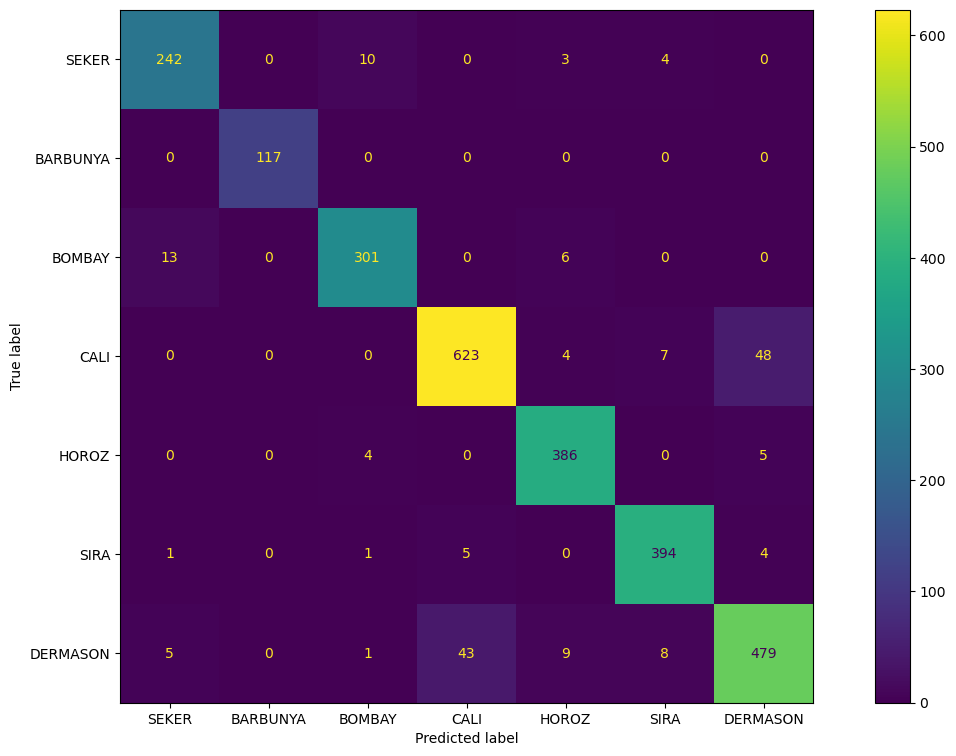

In [17]:

ConfusionMatrix = confusion_matrix(Predictions, yTest)
Display = ConfusionMatrixDisplay(ConfusionMatrix,display_labels=labels)
Fig, Ax = plt.subplots(figsize=(16, 9))
Display.plot(ax=Ax);

## Hands-on Excersice




In STEP 14: Parameter Search, adjust the value of C (e.g., C=[0.01, 0.1, 1, 5, 8, 10, 100]) and visualize the output scores. Observe how performance varies as C increases or decreases, and determine whether there is a value of C that yields better accuracy than C=8.